In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from scipy.stats import pearsonr
from scipy.stats import pearsonr
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm

train_data = pd.read_csv('https://www.dropbox.com/scl/fi/52fq7m3blvjh98ylb8cj2/train.csv?rlkey=mfyb5gc9mpou11dzp70pwsejw&dl=1')
test_data = pd.read_csv('https://www.dropbox.com/scl/fi/faiqiqhmdvswmxdovtlkw/test.csv?rlkey=aqvj7rea2ekfkq437q6d9a8q1&dl=1')

# Handle low relationship data

In [ ]:
#Filter columns with missing percentage more than 50
missing = train_data.isnull().sum() / len(train_data) * 100
missing_over_50 = missing[missing > 50]
print(missing_over_50)

Alley          93.767123
PoolQC         99.520548
Fence          80.753425
MiscFeature    96.301370
dtype: float64


In [ ]:
#Drop variables with high missing percentage
train_data = train_data.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence'])
test_data = test_data.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence'])

#Clean Data

In [ ]:
#Create a new variable 'TotalArea'
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])
train_data['TotalArea'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']
test_data['TotalArea'] = test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF']

#Identify numeric and categorical features
num_features = train_data.select_dtypes(include=[np.number]).columns.tolist()
cat_features = train_data.select_dtypes(exclude=[np.number]).columns.tolist()

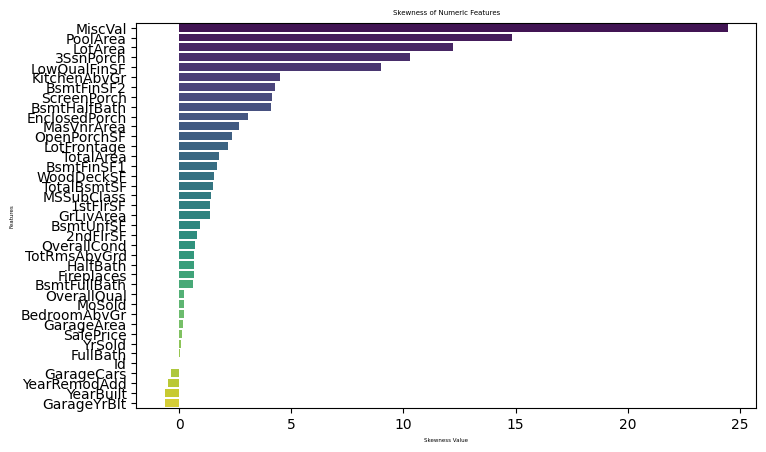

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Select numeric features
numeric_features = train_data.dtypes[train_data.dtypes != 'object'].index
#Calculate skewness
skewed_features = train_data[numeric_features].apply(lambda x: x.skew()).sort_values(ascending=False)
#Plot skewness
plt.figure(figsize=(8,5))
sns.barplot(y=skewed_features.index, x=skewed_features.values, palette="viridis")
plt.xlabel('Skewness Value', fontsize=4)
plt.ylabel('Features', fontsize=4)
plt.title('Skewness of Numeric Features', fontsize=5)
plt.show()

In [ ]:
#Filter those skeweness are greater than 1
numeric_features = train_data.dtypes[train_data.dtypes != 'object'].index
skewed_features = train_data[numeric_features].apply(lambda x: x.skew()).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 1]

#log high skew variables
for feature in high_skew.index:
    train_data[feature] = np.log1p(train_data[feature])
    test_data[feature] = np.log1p(test_data[feature])

#Fill Nan
for feature in num_features:
    if feature != 'SalePrice':
        median_value = train_data[feature].median()
        train_data[feature].fillna(median_value, inplace=True)
        test_data[feature].fillna(median_value, inplace=True)
for feature in cat_features:
    mode_value = train_data[feature].mode()[0]
    train_data[feature].fillna(mode_value, inplace=True)
    test_data[feature].fillna(mode_value, inplace=True)

#Set dummy variables
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)
final_features = list(set(train_data.columns).intersection(test_data.columns))

#Redefine training and testing data
X = train_data[final_features]
test_X = test_data[final_features]
y = train_data['SalePrice']
median_total_area = train_data['TotalArea'].median()
test_X['TotalArea'].fillna(median_total_area, inplace=True)

<ipython-input-6-c7b103542d34>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X['TotalArea'].fillna(median_total_area, inplace=True)


## BH Method

In [ ]:
#Plot p-values for each feature
p_values = {}
for feature in X.columns:
    corr, p = pearsonr(X[feature], y)
    p_values[feature] = p

pvals = np.array(list(p_values.values()))
fig = px.histogram(x=pvals)
fig.update_layout(
    title='p values',
    xaxis=dict(title='p values'),
    yaxis=dict(title='count')
)
fig.show()

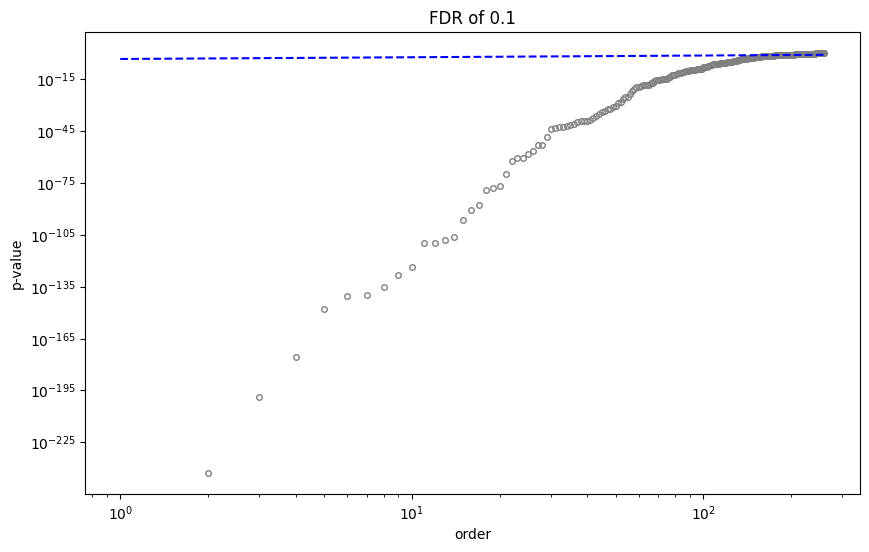

In [ ]:
# FDR curve and determine threshold
def fdr_cut(pvals, q=0.1):
    pvals = np.sort(pvals[~np.isnan(pvals)])
    N = len(pvals)
    k = np.argsort(pvals, kind='mergesort') + 1

    alpha = np.max(pvals[pvals <= (q * k / N)])

    plt.figure(figsize=(10, 6))
    plt.plot(pvals, 'o', markersize=4, markerfacecolor='none', markeredgecolor='gray')
    plt.plot(np.arange(1, N + 1), q * np.arange(1, N + 1) / N, color='blue', linestyle='--')
    plt.xlabel('order')
    plt.ylabel('p-value')
    plt.title(f'FDR of {q}')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

    return alpha

#Get the threshold using FDR cut
alpha_threshold = fdr_cut(pvals)

#Filter features based on p-value threshold
selected_features = [feature for feature, pval in p_values.items() if pval < alpha_threshold]
X_bh = X[selected_features]
test_X_bh = test_X[selected_features]

In [ ]:
#Estimate Multiple Linear Regression Model
stat_model = sm.OLS(y,X_bh)
result_new = stat_model.fit()
summary_table = result_new.summary().tables[1].as_html()
summary_table = pd.read_html(summary_table,header=0,index_col=0)[0]

from google.colab import drive
drive.mount('/content/drive')

summary_table.to_csv('/content/drive/MyDrive/regression.csv')

MessageError: ignored

In [ ]:
print(result_new.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     94.26
Date:                Fri, 18 Aug 2023   Prob (F-statistic):               0.00
Time:                        08:02:53   Log-Likelihood:                 1187.1
No. Observations:                1460   AIC:                            -2022.
Df Residuals:                    1284   BIC:                            -1092.
Df Model:                         175                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
SaleCondition_Partial    -0.05

In [ ]:
#Model training
model_final_10 = LinearRegression()
model_final_10.fit(X_bh, y)

final_predictions = model_final_10.predict(test_X_bh)
final_predictions = np.expm1(final_predictions)
final_predictions

array([120948.63793239, 157802.11709339, 182224.46407005, ...,
       164406.95954202, 121225.28906724, 218886.16804005])

In [ ]:
#Generate the submission file
from google.colab import drive
drive.mount('/content/drive')
sample_submission_df = pd.read_csv('https://www.dropbox.com/scl/fi/fxiwfe47v7odz6qdukl0h/sample_submission.csv?rlkey=v8eknwjn58j9t0v9wu856yx6c&dl=1')
sample_submission_df['SalePrice'] = final_predictions
sample_submission_df.to_csv('/content/drive/MyDrive/Assignment 2.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
